In [2]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/code/')
root = os.path.dirname(os.path.dirname(os.getcwd()))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [3]:
# Load results of the fitting procedure

subject = 1
volume_space=True
semantic_discrim_type = 'all_coco_categ'
fitting_type = 'full_midlevel_plus_%s'%semantic_discrim_type
# fitting_type = 'full_midlevel_plus_semantic_%s'%semantic_discrim_type

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/full_midlevel_plus_all_coco_categ/Jan-27-2022_2335_58/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'corr_each_feature', 'discrim_each_axis', 'discrim_type_list', 'semantic_feature_set', 'use_pca_st_feats', 'use_lda_st_feats', 'lda_discrim_type', 'use_pca_pyr_feats_hl', 'pyramid_feature_info', 'group_all_hl_feats', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'gabor_feature_info', 

In [4]:
out['partial_version_names']

['full_combined_model',
 'just_gabor_solo',
 'leave_out_gabor_solo',
 'just_pyramid_texture',
 'leave_out_pyramid_texture',
 'pyramid_texture_just_lower-level_no_other_modules',
 'pyramid_texture_just_higher-level_no_other_modules',
 'pyramid_texture_just_lower-level_plus_other_modules',
 'pyramid_texture_just_higher-level_plus_other_modules',
 'just_sketch_tokens',
 'leave_out_sketch_tokens',
 'just_semantic_coco_things_categ',
 'leave_out_semantic_coco_things_categ',
 'just_semantic_coco_stuff_categ',
 'leave_out_semantic_coco_stuff_categ']

In [16]:
np.array(out['partial_version_names'])[np.array([2, 4, 10, 12, 14])]

array(['leave_out_gabor_solo', 'leave_out_pyramid_texture',
       'leave_out_sketch_tokens', 'leave_out_semantic_coco_things_categ',
       'leave_out_semantic_coco_stuff_categ'], dtype='<U52')

In [11]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


leave_out_semantic
just_semantic


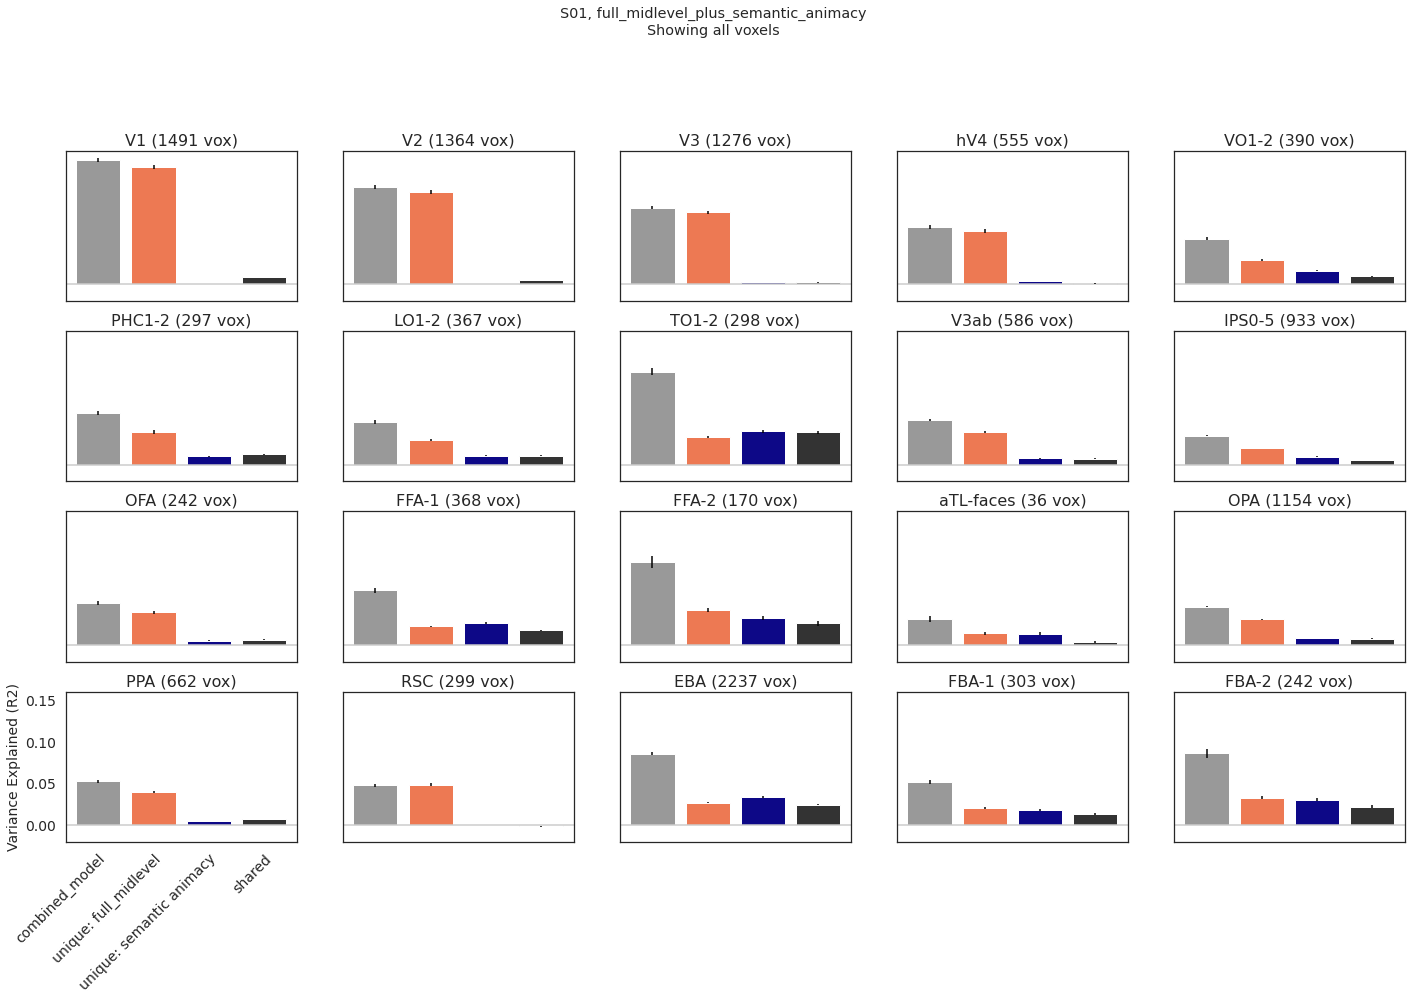

In [30]:
pp0 = 0
pp1 = 12
pp2 = 11
print(out['partial_version_names'][pp1])
print(out['partial_version_names'][pp2])
# for each voxel, choosing which fits to use based on its best layer
val_r2 = out['val_r2']

name1 = 'full_midlevel'
name2 = 'semantic %s'%semantic_discrim_type

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.16])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)

# if fig_save_folder is not None:
#     plt.savefig(os.path.join(fig_save_folder,'Varpart_alexnet_semantic_bars_eachroi.pdf'))
#     plt.savefig(os.path.join(fig_save_folder,'Varpart_alexnet_semantic_bars_eachroi.png'))

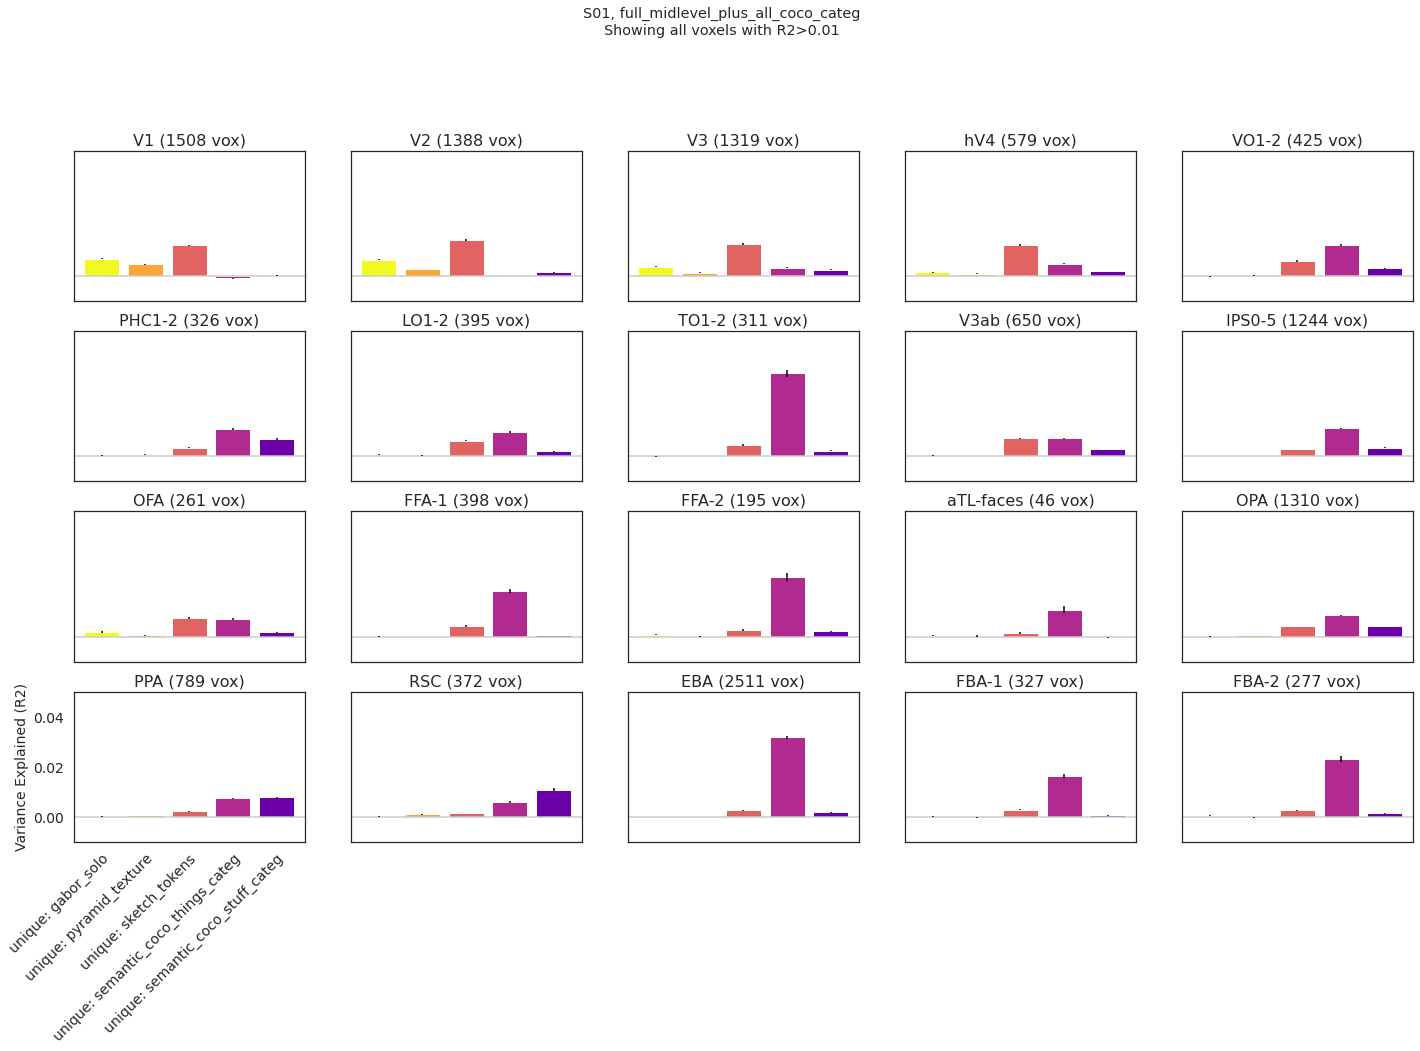

In [20]:
ppinds = [2, 4, 10, 12, 14]
ve_names = ['unique: '+out['partial_version_names'][pp][10:] for pp in ppinds]
var_expl = np.tile(out['val_r2'][:,0:1], [1,5]) - out['val_r2'][:,ppinds]

colors = cm.plasma(np.linspace(0,1,len(ppinds)+1))
colors = np.flipud(colors)

r2_thresh = 0.01
inds2use = out['val_r2'][:,0]>r2_thresh

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.05])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels with R2>%.2f'%(subject, fitting_type, r2_thresh))
plt.gcf().subplots_adjust(bottom=0.4)


In [22]:
from utils import stats_utils
from plotting import plot_prf_params

port=13333

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity', 'pRF angle', \
         'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [9, 360, 9]

ppinds = [2, 4, 10, 12, 14]
ve_names = ['unique: '+out['partial_version_names'][pp][10:] for pp in ppinds]
var_expl = np.tile(out['val_r2'][:,0:1], [1,5]) - out['val_r2'][:,ppinds]
max_ind = (np.argmax(var_expl, axis=1)+1).astype(np.float32)

maps += [copy.deepcopy(np.sqrt(var_expl[:,ii])) for ii in range(5)] + [copy.deepcopy(max_ind)]

names  += ve_names
names += ['unique var greatest for which feature set?']
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'PuBu', 'plasma_r']
mins += [0, 0, 0, 0, 0, 0]
maxes += [0.8, 0.8, 0.8, 0.8, 0.8, 6]

vox2plot = out['val_r2'][:,0]>=0.01

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:13333
Started server on port 13333


In [19]:
from utils import stats_utils
from plotting import plot_prf_params

port=63333

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity', 'pRF angle', \
         'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [7, 360, 8.4]

pp0 = 0
pp1 = 11
pp2 = 12
print(out['partial_version_names'][pp1])
print(out['partial_version_names'][pp2])
# for each voxel, choosing which fits to use based on its best layer
val_r2 = out['val_r2']

name1 = 'semantic %s'%semantic_discrim_type
name2 = 'full_midlevel'

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)
max_ind = (np.argmax(var_expl[:,1:3], axis=1)+1).astype(np.float32)

maps += [copy.deepcopy(np.sqrt(var_expl[:,ii])) for ii in range(4)] + [copy.deepcopy(max_ind)]

names  += ['Concat model','Unique var: %s'%name1, 'Unique var: %s'%name2, 'Shared variance', \
          'Unique var greater for %s or %s'%(name1, name2)]
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'plasma_r']
mins += [0, 0, 0, 0, 0]
maxes += [0.8, 0.8, 0.8, 0.8, 3]

vox2plot = val_r2[:,0]>=0

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)


just_semantic
leave_out_semantic
Data is in 3d volume space
navigate browser to: 127.0.0.1:63333


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


Started server on port 63333
